In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import os

In [6]:
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.B = nn.Parameter(scale * torch.randn(in_features, out_features), requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return torch.cat([x, fourier], dim=-1) 

In [7]:
class Network(nn.Module):
    def __init__(self, num_input=2, fourier_features=10, layers=[64, 64, 64], num_output=3, scale=10.0):
        super(Network, self).__init__()
        self.fourier = FourierFeatures(num_input, fourier_features, scale)
        input_size = num_input + 2*fourier_features
        self.input_layer = nn.Linear(input_size, layers[0])
        self.hidden_layer = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layer.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], num_output)

    def forward(self, x):
        x = self.fourier(x)
        out = torch.tanh(self.input_layer(x))
        for layer in self.hidden_layer:
            out = torch.tanh(layer(out))
        out = self.output_layer(out)
        return out

In [8]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)

        # Assumptions
        self.rho=1.0
        self.nu=0.001
        self.u0=1.0

        # Domain_Definition
        dx=0.005
        dy=0.005
        self.x=torch.arange(0,1+dx,dx)
        self.y=torch.arange(0,1+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T
        self.X.requires_grad = True

        # Boundary_condition_input
        dx_b=0.001
        dy_b=0.001
        self.x_b = torch.arange(0,1+dx_b,dx_b)
        self.y_b = torch.arange(0,1+dy_b,dy_b)
        self.rw = torch.stack(torch.meshgrid(self.x_b[-1],self.y_b)).reshape(2,-1).T
        self.lw = torch.stack(torch.meshgrid(self.x_b[0],self.y_b)).reshape(2,-1).T
        self.uw = torch.stack(torch.meshgrid(self.x_b,self.y_b[-1])).reshape(2,-1).T
        self.dw = torch.stack(torch.meshgrid(self.x_b,self.y_b[0])).reshape(2,-1).T
        self.X_train = torch.cat([self.rw, self.lw, self.uw,  self.dw])

        # Boundary_condition_output
        self.uv_rw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_lw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_uw = torch.stack(torch.meshgrid(self.u0*self.x_b[-1],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_dw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.y_b))).reshape(2,-1).T
        self.uv_train = torch.cat([self.uv_rw, self.uv_lw, self.uv_uw,  self.uv_dw])

        # Transfer tensor to GPU
        self.uv_train = self.uv_train.to(self.device)
        self.X_train = self.X_train.to(self.device)
        self.X = self.X.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters())

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=0.01,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-8,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
    #compute derivations
    def gradient(self,input,index):
        output = torch.autograd.grad(
            input,
            self.X,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return output[:,index]

    def loss_f(self):
        #Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        #output of NN for boundary
        self.uv_P_b = self.network(self.X_train)
        self.u_P_b = self.uv_P_b[:,0]
        self.v_P_b = self.uv_P_b[:,1]

        #loss data definition
        self.loss_data = self.criterion(self.u_P_b,self.uv_train[:,0])+self.criterion(self.v_P_b,self.uv_train[:,1])

        #output of NN
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:,0]
        self.v_P = self.uvp_P[:,1]
        self.p_P = self.uvp_P[:,2]

        #compute derivations
        self.du_dx = self.gradient(self.u_P,0)
        self.du_dy = self.gradient(self.u_P,1)
        self.du_dxx= self.gradient(self.du_dx,0)
        self.du_dyy= self.gradient(self.du_dy,1)
        self.dv_dx = self.gradient(self.v_P,0)
        self.dv_dy = self.gradient(self.v_P,1)
        self.dv_dxx= self.gradient(self.dv_dx,0)
        self.dv_dyy= self.gradient(self.dv_dy,1)
        self.dp_dx = self.gradient(self.p_P,0)
        self.dp_dy = self.gradient(self.p_P,1)

        # compute equation loss
        self.con_equ=self.du_dx+self.dv_dy
        self.u_eqn = self.uvp_P[:,0]*self.du_dx + self.uvp_P[:,1]*self.du_dy + self.dp_dx/self.rho - self.nu*(self.du_dxx + self.du_dyy)
        self.v_eqn = self.uvp_P[:,0]*self.dv_dx + self.uvp_P[:,1]*self.dv_dy + self.dp_dy/self.rho - self.nu*(self.dv_dxx + self.dv_dyy)

        #loss PDE definition
        self.loss_pde = self.criterion(self.con_equ,torch.zeros_like(self.con_equ))+self.criterion(self.u_eqn,torch.zeros_like(self.u_eqn))+\
                        self.criterion(self.v_eqn,torch.zeros_like(self.v_eqn))

        #loss function definition
        lambda_bc = 1.0
        lambda_pde = 1.0
        self.loss = lambda_bc * self.loss_data + lambda_pde * self.loss_pde
        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.6f}")
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        plt.colorbar(contour1)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("u")
        plt.subplot(2, 2, 2)
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        plt.colorbar(contour2)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("v")
        plt.subplot(2, 2, 3)
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        plt.colorbar(contour3)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("pressure")
        plt.figure(figsize=(8, 8))
        plt.tight_layout()
        plt.show()

In [9]:
net=Pinns()
net.train(300)
net.plot()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [187]:
torch.save(net.network.state_dict(), '/home/hossein_vasheghani/model_bydata_re=100_FF.pth')

/tmp/ipykernel_648797/3991075550.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.network.load_state_dict(torch.load('/home/hossein_vasheghani/model_bydata_re=100_FF.

Iteration 0, Loss: 4.520626
Iteration 10, Loss: 0.190133
Iteration 20, Loss: 0.105869
Iteration 30, Loss: 0.072412
Iteration 40, Loss: 0.052663
Iteration 50, Loss: 0.042867
Iteration 60, Loss: 0.037209
Iteration 70, Loss: 0.032929
Iteration 80, Loss: 0.029703
Iteration 90, Loss: 0.027167
Iteration 100, Loss: 0.025083
Iteration 110, Loss: 0.023332
Iteration 120, Loss: 0.021843
Iteration 130, Loss: 0.020562
Iteration 140, Loss: 0.019449
Iteration 150, Loss: 0.018470
Iteration 160, Loss: 0.017602
Iteration 170, Loss: 0.016824
Iteration 180, Loss: 0.016123
Iteration 190, Loss: 0.015487
Iteration 200, Loss: 0.014908
Iteration 210, Loss: 0.014378
Iteration 220, Loss: 0.013891
Iteration 230, Loss: 0.013442
Iteration 240, Loss: 0.013028
Iteration 250, Loss: 0.012645
Iteration 260, Loss: 0.012288
Iteration 270, Loss: 0.011957
Iteration 280, Loss: 0.011647
Iteration 290, Loss: 0.011358
Iteration 300, Loss: 0.011087
Iteration 310, Loss: 0.010833
Iteration 320, Loss: 0.010593
Iteration 330, Loss: 

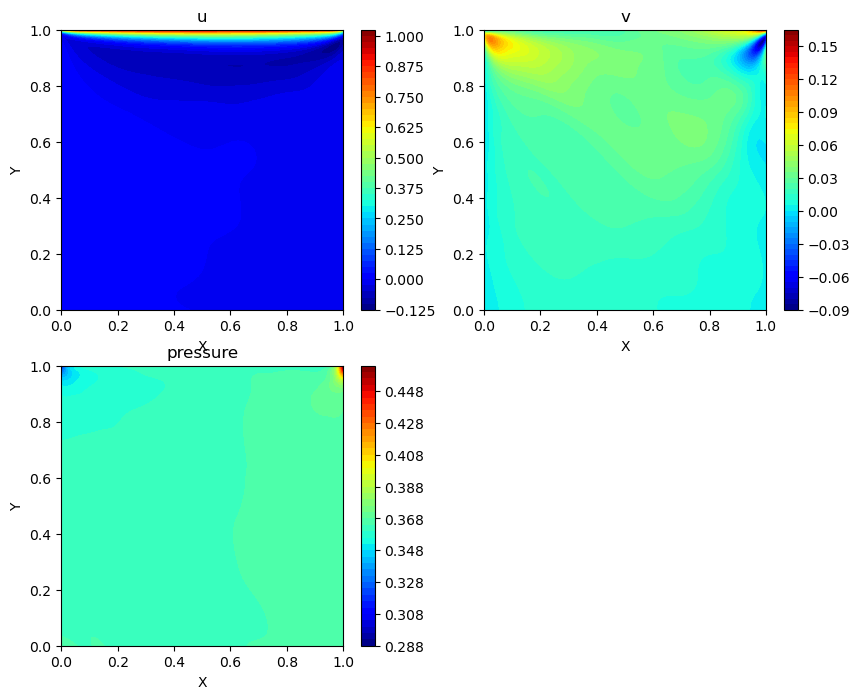

<Figure size 800x800 with 0 Axes>

In [189]:
net = Pinns()
net.network.load_state_dict(torch.load('/home/hossein_vasheghani/model_bydata_re=100_FF.pth'))
net.train(num_epochs=3000)
net.plot()

In [159]:
# Given validation data
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.18109, -0.20196, -0.22220, -0.29730, -0.38289, -0.27805, -0.10648, -0.06080,
                          0.05702, 0.18719, 0.33304, 0.46604, 0.51117, 0.57492, 0.65928, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.27485 , 0.29012 , 0.30353 , 0.32627 , 0.37095 , 0.33075 , 0.32235 , 0.02526 ,
                          -0.31966, -0.42665 , -0.51550, -0.39188 , -0.33714 , -0.27669 , -0.21388 , 0])

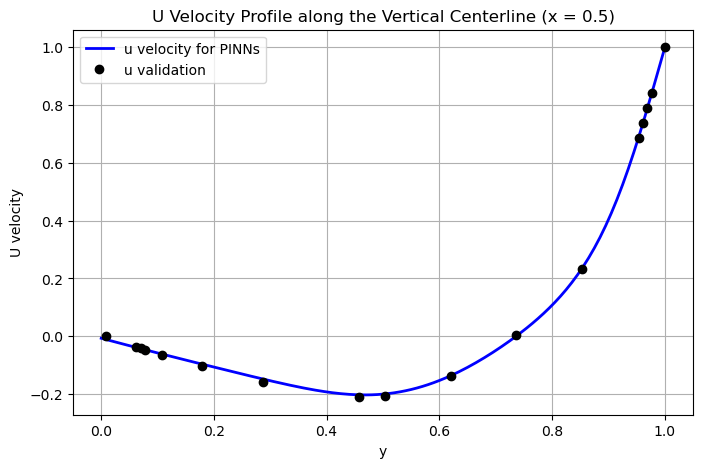

In [185]:
u=net.uvp_P[:,0]
u=u.reshape(len(net.x), len(net.y)).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
x=torch.arange(0,1+1/128,1/128)
plt.plot(net.x, u[101,:], 'b-', linewidth=2, label='u velocity for PINNs')
plt.plot(x_validation, u_validation2, 'ko', label="u validation", markersize=6, linewidth=2)
plt.xlabel("y")
plt.ylabel("U velocity")
plt.title("U Velocity Profile along the Vertical Centerline (x = 0.5)")
plt.legend()
plt.grid(True)
plt.show()

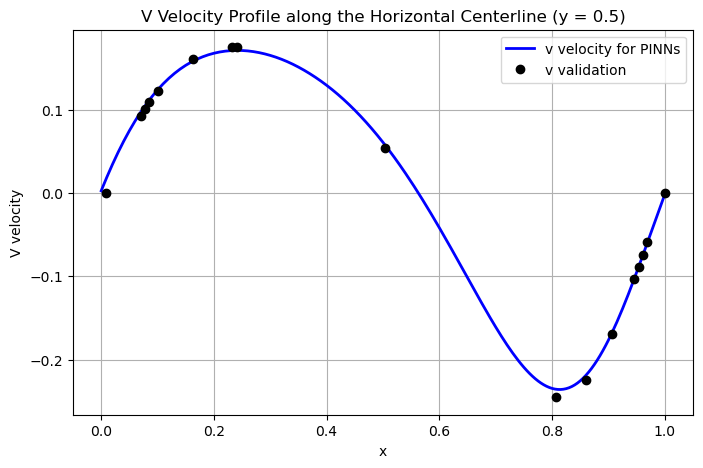

In [186]:
v=net.uvp_P[:,1]
v=v.reshape(len(net.x), len(net.y)).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
x=torch.arange(0,1+1/128,1/128)
plt.plot(net.x, v[:,101], 'b-', linewidth=2, label='v velocity for PINNs')
plt.plot(y_validation, v_validation2, 'ko', label="v validation", markersize=6, linewidth=2)
plt.xlabel("x")
plt.ylabel("V velocity")
plt.title("V Velocity Profile along the Horizontal Centerline (y = 0.5)")
plt.legend()
plt.grid(True)
plt.show()